<a href="https://colab.research.google.com/github/dannyjammooa/LANL/blob/main/Fixed_2_and_4_qubit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install qiskit;

     |████████████████████████████████| 6.1 MB 27.1 MB/s 
     |████████████████████████████████| 18.0 MB 1.8 MB/s 
     |████████████████████████████████| 235 kB 41.2 MB/s 
     |████████████████████████████████| 207 kB 56.7 MB/s 
     |████████████████████████████████| 2.1 MB 21.0 MB/s 
     |████████████████████████████████| 200 kB 43.7 MB/s 
     |████████████████████████████████| 1.4 MB 31.1 MB/s 
     |████████████████████████████████| 635 kB 65.5 MB/s 
     |████████████████████████████████| 68 kB 6.7 MB/s 
     |████████████████████████████████| 33.9 MB 19 kB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 943 kB 26.5 MB/s 
     |████████████████████████████████| 3.2 MB 26.0 MB/s 
     |████████████████████████████████| 6.3 MB 42.0 MB/s 
  Created wheel for qiskit: filename=qiskit-0.29.0-py3-none-any.whl size=11179 sha256=97160c85026befbe7997b5561834e2282fe29b00f8d9e46b3f240530930f8639
  Stored in directory: /root/.cache/pip/wh

In [2]:
import numpy as np
import warnings
from tqdm.auto import tqdm
import qiskit as qk
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer, assemble
from qiskit.visualization import circuit_drawer, plot_histogram, plot_state_qsphere
from qiskit import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import linalg as la
from sympy import *
from sympy import Matrix, Inverse, diag, GramSchmidt
from sympy import Symbol
from sympy.physics.quantum import TensorProduct
from numpy.linalg import inv
import math
pi = np.pi
%matplotlib inline
from qiskit import IBMQ
from qiskit.quantum_info import Statevector
from qiskit import Aer
from qiskit.visualization import plot_state_city
IBMQ.save_account('5e716052aec669f447b21719efe891c73d8d13c7d00c226b16bac3004940300f49f9c54ab14a0d79d871a0aafbc6992f056be94eddb98ab80ff45d711c30f541')
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

# Functions

## Measures

In [3]:
#Measurment Functions

#execute the circuit using qasm_simulator as backend
def execute_QC(quantum_circuit,shot):
  simulator = Aer.get_backend('qasm_simulator')
  result = execute(quantum_circuit, backend=simulator, shots=shot).result().get_counts()
  return result

def execute_QC_IBM(quantum_circuit,shot):
  provider = IBMQ.get_provider('ibm-q')
  qcomp = provider.get_backend('ibmq_5_yorktown')
  result = execute(quantum_circuit, backend=qcomp, shots=shot).result().get_counts()
  return result

#X-basis
def X_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)
    return qc

#Y-basis
def Y_measurement(qc, qubit, cbit):
   """Measure 'qubit' in the Y-basis, and store the result in 'cbit'"""
   qc.sdg(qubit)
   qc.h(qubit)
   qc.measure(qubit, cbit)
   return qc

#ZZ-basis
def ZZ_measurement(qc,qubit1,qubit2,cbit1,cbit2):
  qc.measure(qubit1,cbit1)
  qc.measure(qubit2,cbit2)
  return qc

#XX-basis
def XX_measurement(qc,qubit1,qubit2,cbit1,cbit2):
  qc.h(qubit1)
  qc.h(qubit2)
  qc.measure(qubit1,cbit1)
  qc.measure(qubit2,cbit2)
  return qc

#YY-basis
def YY_measurement(qc,qubit1,qubit2,cbit1,cbit2):
  qc.sdg(qubit1)
  qc.sdg(qubit2)
  qc.h(qubit1)
  qc.h(qubit2)
  qc.measure(qubit1,cbit1)
  qc.measure(qubit2,cbit2)
  return qc

#combinding all measurement into one function
def Measure(qc, basis, qubit1,qubit2,cbit1,cbit2):
  if basis == 'Z1':
    qc.measure([qubit1],[cbit1])
  elif basis =='Z2':
    qc.measure([qubit2],[cbit2])
  elif basis == 'Y':
    Y_measurement(qc,qubit1,cbit1)
  elif basis == 'X':
    X_measurement(qc,qubit1,cbit1)
  elif basis == 'ZZ':
    ZZ_measurement(qc, qubit1,qubit2,cbit1,cbit2)
  elif basis == 'YY':
    YY_measurement(qc, qubit1,qubit2,cbit1,cbit2)
  elif basis == 'XX':
    XX_measurement(qc, qubit1,qubit2,cbit1,cbit2)
  return qc

## Gates and running Circuits

In [4]:
#choosing our initial state
def Initial_State(quantum_register,IS,vect,nqbits):
  quantum_circuit = QuantumCircuit(quantum_register)
  if IS == 'odd': #skips odd numbered qubits
    for idx in range(nqbits):
      if idx%2 == 0: 
        continue
      else:
        quantum_circuit.x(idx)
  elif IS =='even': #skips odd numbered qubits
    for idx in range(nqbits):
      if idx%2 == 0: 
        quantum_circuit.x(idx)
      else:
        continue
  elif IS == 'alldown':
    for idx in range(nqbits):
      quantum_circuit.x(idx)
  elif IS =='allup':
    for idx in range(nqbits):
      quantum_circuit.id(idx)
  elif IS == '01':
    for idx in range(nqbits):
      if idx%2 == 0:
        quantum_circuit.h(idx)
        quantum_circuit.cx(idx,idx+1)
      else:
        quantum_circuit.x(idx)
  elif IS == '11':
    for idx in range(nqbits):
      quantum_circuit.x(idx)
      if idx%2 == 0:
        quantum_circuit.h(idx)
        quantum_circuit.cx(idx,idx+1)
      else:
        continue
  elif IS =='split':
    for idx in range(nqbits):
      if idx == nqbits/2:
        break
      else: 
        quantum_circuit.x(idx)
  elif IS =='vec': 
    quantum_circuit.initialize(vect, [quantum_register[0],quantum_register[1],quantum_register[2],quantum_register[3]])
  elif IS =='vec2': 
    quantum_circuit.initialize(vect, [quantum_register[0],quantum_register[1]])
  return quantum_circuit

#N(alpha,beta,gamma) gate from the paper
#Half time step
def SWAP1(var,t):
  Thalf = 0/5*t
  a = var[0]
  b = var[1]
  y = var[2]
  theta = pi/2 - 2*y*Thalf
  phi = 2*a*Thalf -pi/2
  lamda = pi/2 -2*b*Thalf
  qc = QuantumCircuit(2, name='Half')
  qc.rz(-pi/2,1)
  qc.cx(1,0)
  qc.rz(theta,0)
  qc.ry(phi,1)
  qc.cx(0,1)
  qc.ry(lamda,1)
  qc.cx(1,0)
  qc.rz(pi/2,0)
  return qc

#N(alpha,beta,gamma) gate from the paper
#Full time step
def SWAP2(var,t):
  a = var[0]
  b = var[1]
  y = var[2]
  theta = pi/2 - 2*y*t  #angle that depend on the zz two-body coefficient
  phi = 2*a*t -pi/2     #angle that depend on the xx two-body coefficient
  lamda = pi/2 -2*b*t   #angle that depend on the yy two-body coefficient
  qc = QuantumCircuit(2, name='Full')
  qc.rz(-pi/2,1)
  qc.cx(1,0)
  qc.rz(theta,0)
  qc.ry(phi,1)
  qc.cx(0,1)
  qc.ry(lamda,1)
  qc.cx(1,0)
  qc.rz(pi/2,0)
  return qc

#The full unitary time evolution 
def Unitary(quantum_circuit,var,nqbits,h,t):
  Thalf = 0.5*t
  psi = h*Thalf  #angle that depends on the z one-body coefficient
  #one-body term
  for idx in range(nqbits):
    quantum_circuit.rz(psi,idx) 
  quantum_circuit.barrier()
  #two-body term / odd qubits swaped/ half time step
  for idx in range(nqbits):
    if idx%2 == 0:
      continue
    else:
      if idx == nqbits-1:
        break
      else:
        quantum_circuit.append(SWAP1(var,t), [idx,idx+1])
  #two-body term / even qubits swaped/ full time step
  for idx in range(nqbits):
    if idx%2 == 1:
      continue
    else:
      if idx == nqbits:
        break
      else:
        quantum_circuit.append(SWAP2(var,t), [idx,idx+1])
  #two-body term / odd qubits swaped/ half time step
  for idx in range(nqbits):
    if idx%2 == 0:
      continue
    else:
      if idx == nqbits-1:
        break
      else:
        quantum_circuit.append(SWAP1(var,t), [idx,idx+1])
  quantum_circuit.barrier()
  #one-body term
  for idx in range(nqbits):
    quantum_circuit.rz(psi,idx) 
  return quantum_circuit

#applies trotter steps
def Trotter(quantum_circuit, numTstep, nqbits, var, h, t):
  for i in range(numTstep):
      Unitary(quantum_circuit, var, nqbits, h, t)
  return quantum_circuit

#creates our quantum Circuit
def Quantum_Circuit(IS,vect,nqbits, var, numTstep,h,t):
     QC = QuantumRegister(nqbits,'q')
     QCI = Initial_State(QC,IS,vect,nqbits)
     QCI.barrier()
     Trotter(QCI,numTstep,nqbits,var,h,t)
     QCI.barrier()
     return QCI

#creates/measures/excute our quantum circuit and stores the probabilies of measured circuit
def Results_IBM(IS,vec,nqbits,numTstep,basis,var,shots,h,t):
  Energy = []
  for initialstate in IS:
    E = []
    qc = Quantum_Circuit(initialstate,vec,nqbits,var,numTstep,h,t)
    for measure_circuit in basis:
      for i in range(nqbits):
        if measure_circuit == basis[0]:
          qx = QuantumCircuit(nqbits,2)
          QX = qc + Measure(qx,measure_circuit,i,i+1,0,1)
        else:
          if i == qbit-1:
            break
          else:
            qx = QuantumCircuit(nqbits,2)
            QX = qc + Measure(qx,measure_circuit,i,i+1,0,1)
        counts = execute_QC_IBM(QX,shots)
        probs = {}
        for output in ['00','01', '10', '11']:
          if output in counts:
            probs[output] = counts[output]/shots
          else:
            probs[output] = 0
        E.append(probs['00']-probs['01']-probs['10']+probs['11'])
    Energy.append(E)
  return Energy

def Results(IS,vec,nqbits,numTstep,basis,var,shots,h,t):
  Energy = []
  for initialstate in IS:
    E = []
    qc = Quantum_Circuit(initialstate,vec,nqbits,var,numTstep,h,t)
    for measure_circuit in basis:
      for i in range(nqbits):
        if measure_circuit == basis[0]:
          qx = QuantumCircuit(nqbits,2)
          QX = qc + Measure(qx,measure_circuit,i,i+1,0,1)
        else:
          if i == qbit-1:
            break
          else:
            qx = QuantumCircuit(nqbits,2)
            QX = qc + Measure(qx,measure_circuit,i,i+1,0,1)
        counts = execute_QC(QX,shots)
        probs = {}
        for output in ['00','01', '10', '11']:
          if output in counts:
            probs[output] = counts[output]/shots
          else:
            probs[output] = 0
        E.append(probs['00']-probs['01']-probs['10']+probs['11'])
    Energy.append(E)
  return Energy

def Energy(E,J,U,h,nqbits):
  Z = []
  ZZ = []
  XX = []
  YY = []
  for i in range(nqbits):
    Z.append(E[i])
  for i in range(nqbits-1):
    ZZ.append(E[i+nqbits])
  for i in range(nqbits-1):
    XX.append(E[i+2*nqbits-1])
  for i in range(nqbits-1):
    YY.append(E[i+3*nqbits-2]) 
  return h*sum(Z)+U*sum(ZZ)-J*sum(XX+YY)

#Two Qubit

## Numerical Calculations

In [ ]:
A =  1
B = 0.3

X = Matrix([[0,1],[1,0]])
Y = Matrix([[0,-1j],[1j,0]])
Z = Matrix([[1,0],[0,-1]])
I = Matrix([[1,0],[0,1]])

XX = TensorProduct(X,X)
YY = TensorProduct(Y,Y)
ZZ = TensorProduct(Z,Z)
Z1 = TensorProduct(I,Z)
Z2 = TensorProduct(Z,I)

H = A*(XX+YY+ZZ) + B*(Z2+Z1)

D = diag(H)
D.eigenvals()
G = D.eigenvects()
L = [Matrix(G[0][2]),Matrix(G[1][2]),Matrix(G[2][2]),Matrix(G[3][2])]
out = GramSchmidt(L,True)
vec_2qb = []
for j in range(4):
  Z = np.zeros(4)
  for i in range(4):
    Z[i] = out[j][i]
  vec_2qb.append(Z)
print('E=',G[0][0],'vec=',vec_2qb[0])
print('E=',G[1][0],'vec=',vec_2qb[1])
print('E=',G[2][0],'vec=',vec_2qb[2])
print('E=',G[3][0],'vec=',vec_2qb[3])

E= 1.60000000000000 vec= [1. 0. 0. 0.]
E= -3.00000000000000 vec= [ 0.          0.70710678 -0.70710678  0.        ]
E= 1.00000000000000 vec= [ 0.         -0.70710678 -0.70710678  0.        ]
E= 0.400000000000000 vec= [0. 0. 0. 1.]


##Simulator

In [ ]:
Shots= 8192 #number of shots
qbit = 2 #size of circuit
trotter = 1 #number of trotter steps
t= 0.1 #time
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['vec2']
ENG = []
for i in tqdm(range(len(vec_2qb))):
  E = Results(PSI,vec_2qb[i],qbit,trotter,basis,Var,Shots,B,t)
  ENG.append(Energy(E[0],-A,A,B,qbit))
for i in range(len(ENG)):
  print('----------------------------------------------------------------------------------------')
  print('|','Numerical Calculations=', G[i][0], 'Quantum Simulation', ENG[i])
  print('----------------------------------------------------------------------------------------')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
/usr/local/lib/python3.7/dist-packages/qiskit/circuit/quantumcircuit.py:933: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)



----------------------------------------------------------------------------------------
| Numerical Calculations= 1.60000000000000 Quantum Simulation 1.579248046875
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
| Numerical Calculations= -3.00000000000000 Quantum Simulation -2.993994140625
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
| Numerical Calculations= 1.00000000000000 Quantum Simulation 1.006005859375
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
| Numerical Calculations= 0.400000000000000 Quantum Simulation 0.388525390625
-----------------------------------------------------------------

## IBM Quantum Computer

In [ ]:
Shots= 8192 #number of shots
qbit = 2 #size of circuit
trotter = 1 #number of trotter steps
t= 0.1 #time
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['vec2']
ENG = []
for i in tqdm(range(len(vec_2qb))):
  E = Results_IBM(PSI,vec_2qb[i],qbit,trotter,basis,Var,Shots,B,t)
  ENG.append(Energy(E[0],-A,A,B,qbit))
for i in range(len(ENG)):
  print('----------------------------------------------------------------------------------------')
  print('|','Numerical Calculations=', G[i][0], 'Quantum Simulation', ENG[i])
  print('----------------------------------------------------------------------------------------')

##Statevector Trotter steps

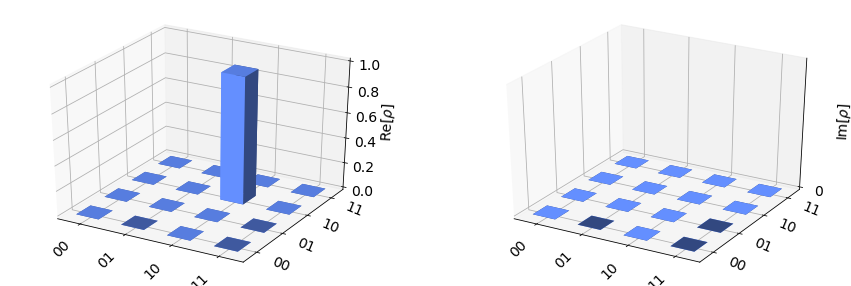

In [ ]:
backend = Aer.get_backend('statevector_simulator')
QCI = QuantumRegister(2)
QC = Initial_State(QCI,'odd',0,2)
plot_state_city(QC)

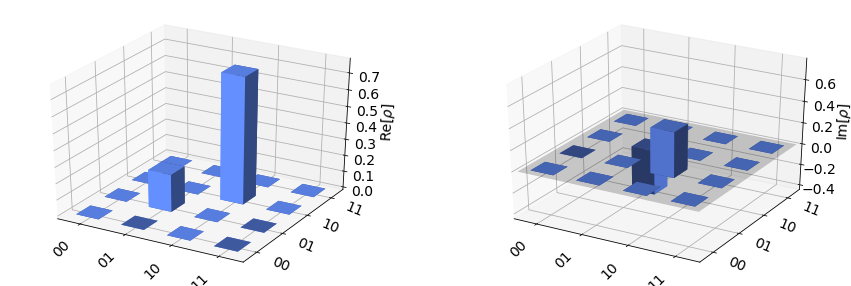

In [ ]:
QC1 = Quantum_Circuit('odd',0,2,[1,1,1],1,0.3,0.25)
plot_state_city(QC1)

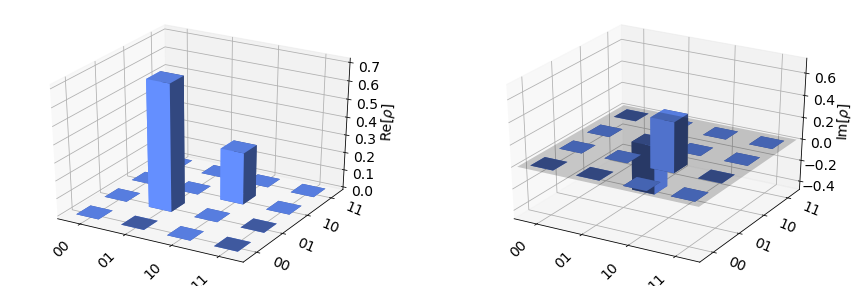

In [ ]:
QC2 = Quantum_Circuit('odd',0,2,[1,1,1],2,0.3,0.25)
plot_state_city(QC2)

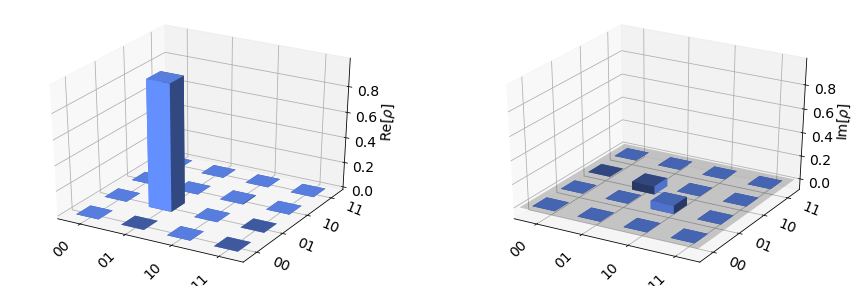

In [ ]:
QC3 = Quantum_Circuit('odd',0,2,[1,1,1],3,0.3,0.25)
plot_state_city(QC3)

#4 qbit

## Numerical Claculations

In [5]:
A =  1
B = 0.3

X = Matrix([[0,1],[1,0]])
Y = Matrix([[0,-1j],[1j,0]])
Z = Matrix([[1,0],[0,-1]])
I = Matrix([[1,0],[0,1]])

#ZZ
Z0Z1 = TensorProduct(I,I,Z,Z)
Z1Z2 = TensorProduct(I,Z,Z,I)
Z2Z3 = TensorProduct(Z,Z,I,I)

#XX
X0X1 = TensorProduct(I,I,X,X)
X1X2 = TensorProduct(I,X,X,I)
X2X3 = TensorProduct(X,X,I,I)

#YY
Y0Y1 = TensorProduct(I,I,Y,Y)
Y1Y2 = TensorProduct(I,Y,Y,I)
Y2Y3 = TensorProduct(Y,Y,I,I)

#Z
Z0 = TensorProduct(I,I,I,Z)
Z1 = TensorProduct(I,I,Z,I)
Z2 = TensorProduct(I,Z,I,I)
Z3 = TensorProduct(Z,I,I,I)

H = A*(X0X1 + X1X2 + X2X3 + Y0Y1 + Y1Y2 +Y2Y3 + Z0Z1 + Z1Z2 + Z2Z3) + B*(Z0+Z1+Z2+Z3)
D = diag(H)
G= D.eigenvects()
D.eigenvals()
LL = [Matrix(G[0][2]),Matrix(G[1][2]),Matrix(G[2][2]),Matrix(G[3][2]),Matrix(G[4][2]),Matrix(G[5][2]),Matrix(G[6][2]),Matrix(G[7][2]),Matrix(G[8][2]),Matrix(G[9][2]),Matrix(G[10][2]),Matrix(G[11][2]),Matrix(G[12][2]),Matrix(G[13][2]),Matrix(G[14][2]),Matrix(G[15][2])]
out = GramSchmidt(LL,True)
VECS = []
for i in range(len(out)):
  I = np.array(out[i])
  I[abs(I)<0.1] = 0
  VECS.append(I)
vec_4qb = []
for j in range(16):
  Z = np.zeros(16)
  for i in range(16):
    Z[i] = VECS[j][i]
  vec_4qb.append(Z)

for i in range(len(vec_4qb)):
  print('--------------------------------------------------------------------------------------------------------------------------')
  print('|','E=',G[i][0],'vec=',vec_4qb[i])
  print('--------------------------------------------------------------------------------------------------------------------------')


--------------------------------------------------------------------------------------------------------------------------
| E= 4.20000000000000 vec= [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
--------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------
| E= 3.60000000000000 vec= [ 0.  -0.5 -0.5  0.  -0.5  0.   0.   0.  -0.5  0.   0.   0.   0.   0.
  0.   0. ]
--------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------
| E= 2.42842712474619 vec= [ 0.         -0.65328148 -0.27059805  0.          0.27059805  0.
  0.          0.          0.65328148  0.          0.          0.
  0.          0.          0.          0.  

## Simulator

In [6]:
Shots= 20000 #number of shots
qbit = 4 #size of circuit
trotter = 1 #number of trotter steps
t= 0.1 #time
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['vec']#['allup','alldown']#,'alldown']
ENG = []
for i in tqdm(range(len(vec_4qb))):
  E = Results(PSI,vec_4qb[i],qbit,trotter,basis,Var,Shots,B,t)
  ENG.append(Energy(E[0],-A,A,B,4))
for i in range(len(ENG)):
  print('----------------------------------------------------------------------------------------')
  print('|','Numerical Calculations=', G[i][0], 'Quantum Simulation', ENG[i])
  print('----------------------------------------------------------------------------------------')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
/usr/local/lib/python3.7/dist-packages/qiskit/circuit/quantumcircuit.py:933: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)



----------------------------------------------------------------------------------------
| Numerical Calculations= 4.20000000000000 Quantum Simulation 4.1955
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
| Numerical Calculations= 3.60000000000000 Quantum Simulation 3.57075
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
| Numerical Calculations= 2.42842712474619 Quantum Simulation 2.3267100000000003
----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------
| Numerical Calculations= -0.400000000000000 Quantum Simulation -0.3821499999999999
------------------------------------------------------------------------

## IBM Quantum Computer

In [ ]:
Shots= 8192 #number of shots
qbit = 4 #size of circuit
trotter = 1 #number of trotter steps
t= 0.1 #time
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['vec']#['allup','alldown']#,'alldown']
ENG = []
for i in tqdm(range(len(vec_4qb))):
  E = Results_IBM(PSI,vec_4qb[i],qbit,trotter,basis,Var,Shots,B,t)
  ENG.append(Energy(E[0],-A,A,B,4))
for i in range(len(ENG)):
  print('----------------------------------------------------------------------------------------')
  print('|','Numerical Calculations=', G[i][0], 'Quantum Simulation', ENG[i])
  print('----------------------------------------------------------------------------------------')

##Statevector Trotter steps

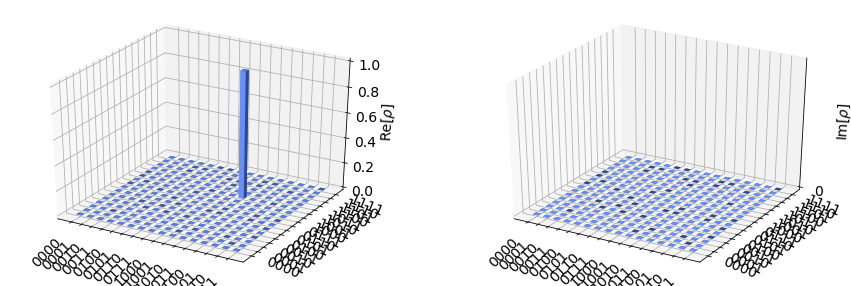

In [ ]:
backend = Aer.get_backend('statevector_simulator')
QCI = QuantumRegister(4)
QC = Initial_State(QCI,'odd',0,4)
plot_state_city(QC)

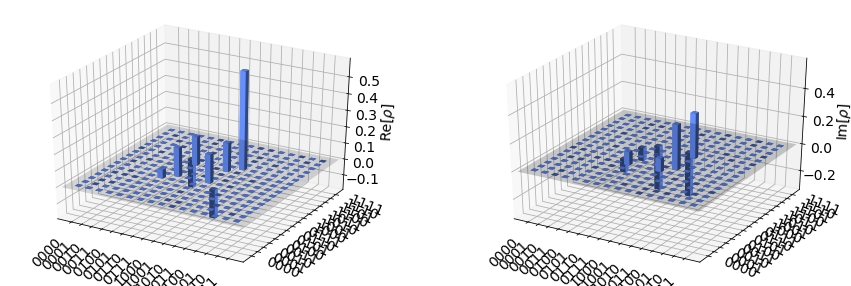

In [ ]:
QC1 = Quantum_Circuit('odd',0,4,[1,1,1],1,0.3,0.25)
plot_state_city(QC1)

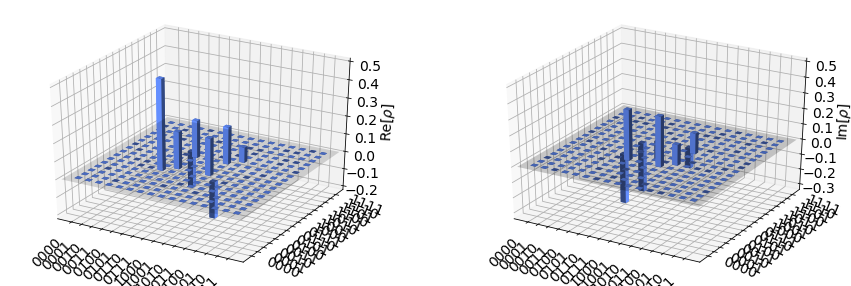

In [ ]:
QC2 = Quantum_Circuit('odd',0,4,[1,1,1],2,0.3,0.25)
plot_state_city(QC2)

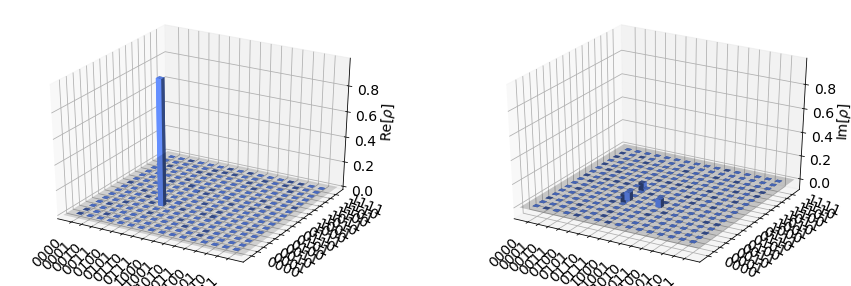

In [ ]:
QC3 = Quantum_Circuit('odd',0,4,[1,1,1],3,0.3,0.25)
plot_state_city(QC3)

##t = Trotter$\cdot \Delta$ t

In [ ]:
# t = 0.1
Shots= 10000 #number of shots
qbit = 4 #size of circuit
trotter = np.arange(1,20,1) #number of trotter steps
t = 0.1
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['vec']
ENG1 = []
Dt1 = []
for i in tqdm(range(len(trotter))):
  delt = t/trotter[i]
  E = Results(PSI,vec_4qb[1],qbit,trotter[i],basis,Var,Shots,B,delt)
  ENG1.append(Energy(E[0],-A,A,B,4))
  Dt1.append(delt)

Text(0, 0.5, 'Energy')

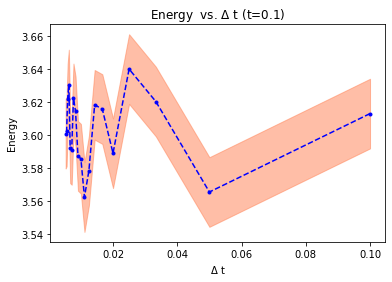

In [ ]:
enstd = np.std(ENG1)
plt.fill_between(Dt1, ENG1+enstd,ENG1-enstd, alpha=0.5, color='coral', label = 'Prior 2sigma')
plt.plot(Dt1,ENG1,'b.--')
plt.title('Energy  vs. $\Delta$ t (t=0.1)')
plt.xlabel('$\Delta$ t')
plt.ylabel('Energy')

In [ ]:
# t = 0.5
Shots= 10000 #number of shots
qbit = 4 #size of circuit
trotter = np.arange(1,20,1) #number of trotter steps
t = 0.5
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['vec']
ENG2 = []
Dt2 = []
for i in tqdm(range(len(trotter))):
  delt = t/trotter[i]
  E = Results(PSI,vec_4qb[1],qbit,trotter[i],basis,Var,Shots,B,delt)
  ENG2.append(Energy(E[0],-A,A,B,4))
  Dt2.append(delt)

Text(0, 0.5, 'Energy')

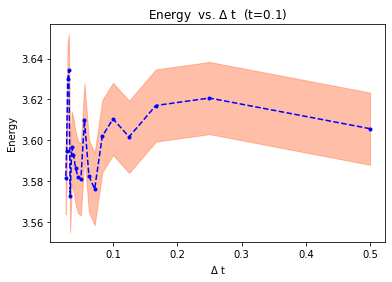

In [ ]:
enstd2 = np.std(ENG2)
plt.fill_between(Dt2, ENG2+enstd2,ENG2-enstd2, alpha=0.5, color='coral', label = 'Prior 2sigma')
plt.plot(Dt2,ENG2,'b.--')
plt.title('Energy  vs. $\Delta$ t  (t=0.1)')
plt.xlabel('$\Delta$ t')
plt.ylabel('Energy')

(3.2, 4.0)

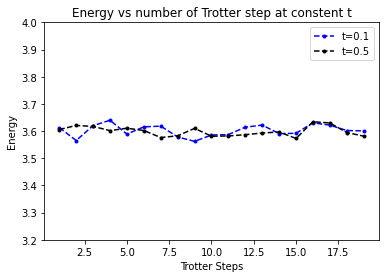

In [ ]:
enstd2 = np.std(ENG2)
plt.plot(trotter,ENG1,'b.--',label='t=0.1')
plt.plot(trotter,ENG2,'k.--',label='t=0.5')
plt.title('Energy vs number of Trotter step at constent t')
plt.xlabel('Trotter Steps')
plt.ylabel('Energy')
plt.legend()
plt.ylim(3.2,4)

## Energy per trotter step

In [ ]:
# t = 0.5
Shots= 10000 #number of shots
qbit = 4 #size of circuit
trotter = np.arange(1,30,1) #number of trotter steps
t = 0.1
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['vec']
ENGT = []
for i in tqdm(range(len(trotter))):
  E = Results(PSI,vec_4qb[2],qbit,trotter[i],basis,Var,Shots,B,t)
  ENGT.append(Energy(E[0],-A,A,B,4))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
/usr/local/lib/python3.7/dist-packages/qiskit/circuit/quantumcircuit.py:933: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


No handles with labels found to put in legend.


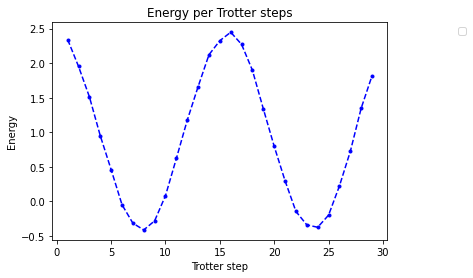

In [ ]:
plt.plot(trotter,ENGT,'b.--')
plt.ylabel('Energy')
plt.xlabel('Trotter step')
plt.title('Energy per Trotter steps')
plt.legend(bbox_to_anchor=(1.25, 1),loc ='upper right')

In [ ]:
# t = 0.5
Shots= 10000 #number of shots
qbit = 4 #size of circuit
trotter = np.arange(1,30,1) #number of trotter steps
t = 0.1
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['vec']
ENGT = []
for i in tqdm(range(len(trotter))):
  E = Results(PSI,vec_4qb[1],qbit,trotter[i],basis,Var,Shots,B,t)
  ENGT.append(Energy(E[0],-A,A,B,4))



(3.4, 3.8)

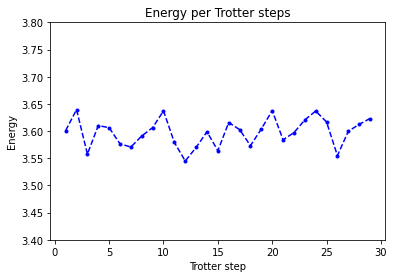

In [ ]:
plt.plot(trotter,ENGT,'b.--')
plt.ylabel('Energy')
plt.xlabel('Trotter step')
plt.title('Energy per Trotter steps')
plt.ylim(3.4,3.8)

In [ ]:
# t = 0.1
Shots= 10000 #number of shots
qbit = 4 #size of circuit
Trotterz = np.arange(1,15,1) #number of trotter steps
t = 0.1
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['vec']
ENGZ0 = []
ENGZ1 = []
ENGZ2 = []
ENGZ3 = []
for i in tqdm(range(len(Trotterz))):
  E = Results(PSI,vec_4qb[2],qbit,Trotterz[i],basis,Var,Shots,B,t)
  ENGZ0.append(E[0][0])
  ENGZ1.append(E[0][1])
  ENGZ2.append(E[0][2])
  ENGZ3.append(E[0][3])

## One-body Terms

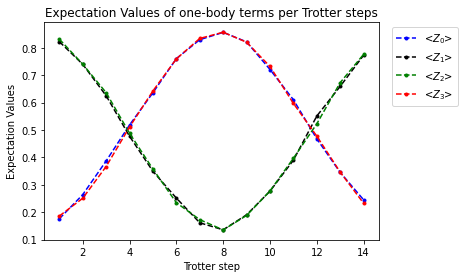

In [ ]:
plt.plot(Trotterz,ENGZ0,'b.--',label = '<$Z_0$>')
plt.plot(Trotterz,ENGZ1,'k.--',label = '<$Z_1$>')
plt.plot(Trotterz,ENGZ2,'g.--',label = '<$Z_2$>')
plt.plot(Trotterz,ENGZ3,'r.--',label = '<$Z_3$>')
plt.ylabel('Expectation Values')
plt.xlabel('Trotter step')
plt.title('Expectation Values of one-body terms per Trotter steps')
plt.legend(bbox_to_anchor=(1.25, 1),loc ='upper right')

In [ ]:
# t = 0.1
Shots= 10000 #number of shots
qbit = 4 #size of circuit
Trotterz = np.arange(1,15,1) #number of trotter steps
t = 0.1
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['vec']
ENGZ0 = []
ENGZ1 = []
ENGZ2 = []
ENGZ3 = []
for i in tqdm(range(len(Trotterz))):
  E = Results(PSI,vec_4qb[1],qbit,Trotterz[i],basis,Var,Shots,B,t)
  ENGZ0.append(E[0][0])
  ENGZ1.append(E[0][1])
  ENGZ2.append(E[0][2])
  ENGZ3.append(E[0][3])

(0.4, 0.6)

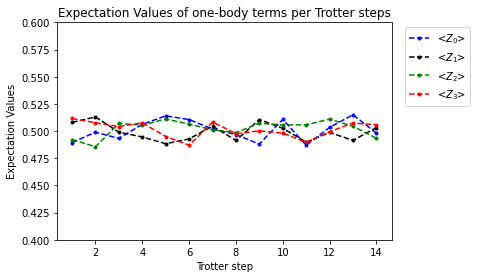

In [ ]:
plt.plot(Trotterz,ENGZ0,'b.--',label = '<$Z_0$>')
plt.plot(Trotterz,ENGZ1,'k.--',label = '<$Z_1$>')
plt.plot(Trotterz,ENGZ2,'g.--',label = '<$Z_2$>')
plt.plot(Trotterz,ENGZ3,'r.--',label = '<$Z_3$>')
plt.ylabel('Expectation Values')
plt.xlabel('Trotter step')
plt.title('Expectation Values of one-body terms per Trotter steps')
plt.legend(bbox_to_anchor=(1.25, 1),loc ='upper right')
plt.ylim(0.4,0.6)

#6 qubit

In [ ]:
Shots= 10000 #number of shots
qbit = 6 #size of circuit
trotter = 1 #number of trotter steps
t= 0.1 #time
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
J = 1 
U = 0.7
h = np.arange(-2,2,0.1)
Var = np.array([J,J,U]) #since alpha=beta=gamma=A in this problem
PSI = ['odd']
ENG = []
for i in tqdm(range(len(h))):
  E = Results(PSI,0,qbit,trotter,basis,Var,Shots,h[i],t)
  ENG.append(Energy(E[0],-A,A,B,4))

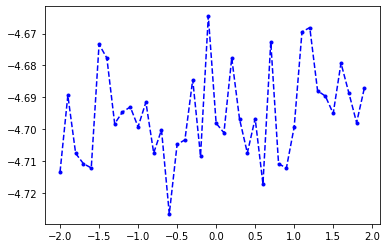

In [ ]:
plt.plot(h,ENG,'b.--')

In [ ]:
Shots= 10000 #number of shots
qbit = 6 #size of circuit
trotterz = np.arange(1,9,1) #number of trotter steps
t= 0.25 #time
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
J = 1 
U = 0.7
h = 0.3
Var = np.array([J,J,U]) #since alpha=beta=gamma=A in this problem
PSI = ['odd']
ENGZ0 = []
ENGZ1 = []
ENGZ2 = []
ENGZ3 = []
ENGZ4 = []
ENGZ5 = []
for i in tqdm(range(len(trotterz))):
  E = Results(PSI,0,qbit,trotterz[i],basis,Var,Shots,h,t)
  ENGZ0.append(E[0][0])
  ENGZ1.append(E[0][1])
  ENGZ2.append(E[0][2])
  ENGZ3.append(E[0][3])
  ENGZ4.append(E[0][4])
  ENGZ5.append(E[0][5])

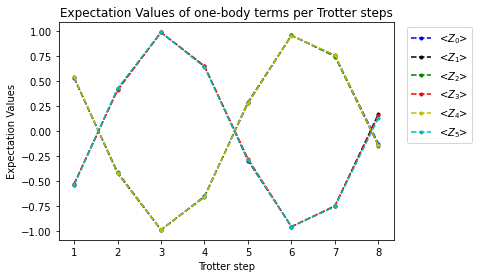

In [ ]:
plt.plot(trotterz,ENGZ0,'b.--',label = '<$Z_0$>')
plt.plot(trotterz,ENGZ1,'k.--',label = '<$Z_1$>')
plt.plot(trotterz,ENGZ2,'g.--',label = '<$Z_2$>')
plt.plot(trotterz,ENGZ3,'r.--',label = '<$Z_3$>')
plt.plot(trotterz,ENGZ4,'y.--',label = '<$Z_4$>')
plt.plot(trotterz,ENGZ5,'c.--',label = '<$Z_5$>')
plt.ylabel('Expectation Values')
plt.xlabel('Trotter step')
plt.title('Expectation Values of one-body terms per Trotter steps')
plt.legend(bbox_to_anchor=(1.25, 1),loc ='upper right')

In [ ]:
Shots= 10000 #number of shots
qbit = 6 #size of circuit
trotter = 1 #number of trotter steps
t= 0.1 #time
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
J = 1 
U = 0.7
h = np.arange(-2,2,0.1)
Var = np.array([J,J,U]) #since alpha=beta=gamma=A in this problem
PSI = ['split']
ENG = []
for i in tqdm(range(len(h))):
  E = Results(PSI,0,qbit,trotter,basis,Var,Shots,h[i],t)
  ENG.append(Energy(E[0],-A,A,B,4))

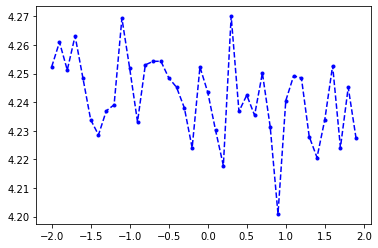

In [ ]:
plt.plot(h,ENG,'b.--')

In [ ]:
Shots= 10000 #number of shots
qbit = 6 #size of circuit
trotterz = np.arange(1,9,1) #number of trotter steps
t= 0.25 #time
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
J = 1 
U = 0.7
h = 0.3
Var = np.array([J,J,U]) #since alpha=beta=gamma=A in this problem
PSI = ['split']
ENGZ0 = []
ENGZ1 = []
ENGZ2 = []
ENGZ3 = []
ENGZ4 = []
ENGZ5 = []
for i in tqdm(range(len(trotterz))):
  E = Results(PSI,0,qbit,trotterz[i],basis,Var,Shots,h,t)
  ENGZ0.append(E[0][0])
  ENGZ1.append(E[0][1])
  ENGZ2.append(E[0][2])
  ENGZ3.append(E[0][3])
  ENGZ4.append(E[0][4])
  ENGZ5.append(E[0][5])

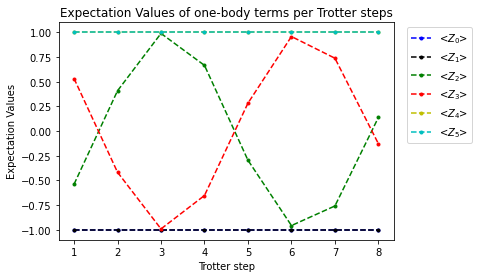

In [ ]:
plt.plot(trotterz,ENGZ0,'b.--',label = '<$Z_0$>')
plt.plot(trotterz,ENGZ1,'k.--',label = '<$Z_1$>')
plt.plot(trotterz,ENGZ2,'g.--',label = '<$Z_2$>')
plt.plot(trotterz,ENGZ3,'r.--',label = '<$Z_3$>')
plt.plot(trotterz,ENGZ4,'y.--',label = '<$Z_4$>')
plt.plot(trotterz,ENGZ5,'c.--',label = '<$Z_5$>')
plt.ylabel('Expectation Values')
plt.xlabel('Trotter step')
plt.title('Expectation Values of one-body terms per Trotter steps')
plt.legend(bbox_to_anchor=(1.25, 1),loc ='upper right')